## Are you a Robot?  ( ͡° ͜ʖ ͡°)

## Purpose and Learning Outcomes
The listed problems align with Objectives 1a and 1b of Social Media Mining course: (1a) Employ machine learning methods to analyze social media datasets and (1b) Mine user behavior patterns on social media.


## Reading [Optional]
Cresci, Stefano, et al. "Cashtag piggybacking: Uncovering spam and bot activity in stock microblogs on Twitter." *ACM Transactions on the Web* 13.2 (2019): 1-27. https://dl.acm.org/doi/pdf/10.1145/3313184.

# Import libraries and connect to Google Drive

In [1]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pylab as pl
shap.initjs()
import torch
import torch.nn as nn
import torch.optim as optim
import copy

In [2]:
# Connect to your Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Change the directory to the Assignment 2 folder uploaded to your Google Drive (which contains the 'data' folder as a subfolder).
# To get the folder location, click on the Files button on the left menu, find the uploaded Assignment 2 folder,
# right click to select 'copy path', and paste the path after %cd below
%cd /content/drive/MyDrive/Social Media Mining/Assignment 2

/content/drive/MyDrive/Social Media Mining/Assignment 2


In [4]:
!ls #should list the contents in the Assignment 2 folder

'Coding Assignment 2.ipynb'   data


# Are you a Robot?

Bots—fake accounts run by algorithms—may be fewer in number than legitimate social media users, but they can profoundly affect human behavior online and offline. A coordinated and synchronized army of bots can often launch large-scale misinformation attacks, selectively amplifying certain narratives and beliefs on social media. These can affect people's voting and stock trading patterns, among other examples. The task of computationally detecting bots is a chicken-and-egg problem: if you identify some pattern that distinguishes bot accounts from humans, the bot creators can create a more elusive bot in the next generation that sidesteps that pattern. Detecting bots thus remains an ongoing research problem.

In this assignment, we will use a dataset Cresci et al. compiled to uncover spam and bot activity patterns related to the stock market. The dataset contains profile metadata (e.g., screen name, profile description, account creation time, number of followers, number of Tweets, and so on) for many user accounts, and gives us the ground truth on whether the account is of a human or a bot. The machine learning task is to classify each data point as a bot ('1') or not ('0').

First, you will load and process the dataset. Some of the input features we will use for classification are already available in the dataset. You will need to derive some additional input features from the existing features.

Second, you will train and test several machine learning models: Logistic Regression, Decision Tree, Random Forest, XGBoost, and two different architectures of a Neural Network.

Third, you will explain the feature importances using the SHAP module.

# Part A: Prepare the Data

## A.1 Load raw data files
There are two files in this dataset:
- The `cresci-stock-2018.tsv` file holds the ground truth label ('bot' or 'human') for each user ID
- The `cresci-stock-2018_tweets.json` file holds the metadata for every user ID.

In [5]:
def load_labels(path_):
    """
    Input
    =====
    path_: The name of a TSV file. The file contains the ground truth labels ('bot' or 'human' label for each user ID).
    There is no header row in this file, so we will need to add one.

    Output
    ======
    df_all_labels: A Pandas dataframe holding the data from the TSV file. Make sure to add a header row where you assign a column name "id" to the first column and "label" to the second column.
    """

    # YOUR CODE HERE
    df_all_labels = pd.read_csv(path_, sep='\t', header=None)
    df_all_labels.columns = ['id', 'label']
    # END CODE
    return df_all_labels

In [6]:
df_all_labels = load_labels("data/cresci-stock-2018.tsv")

In [7]:
df_all_labels.head()

,id,label
0,2391736411,human
1,755095269730095104,human
2,121158213,human
3,39394073,human
4,121370906,human


In [8]:
df_all_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25987 entries, 0 to 25986
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25987 non-null  int64 
 1   label   25987 non-null  object
dtypes: int64(1), object(1)
memory usage: 406.2+ KB


In [9]:
print(f"There are {len(df_all_labels)} ID-to-label mappings in the dataframe.")

There are 25987 ID-to-label mappings in the dataframe.


In [10]:
assert np.all(len(df_all_labels) == 25987), "Your output != Expected output"

In [11]:
assert np.all(df_all_labels.loc[df_all_labels['id'] == 2391736411]['label'] == 'human'), "Your output != Expected output" # this guy is a human

In [12]:
assert np.all(df_all_labels.loc[df_all_labels['id'] == 964641236]['label'] == 'bot'), "Your output != Expected output" # this guy is a bot

In [13]:
def load_user_metadata(path_):
    """
    Input
    =====
    path_: The name of a JSON file. The file contains the metadata for each user account.

    Output
    ======
    json_metadata: Simply load and return the JSON file from the path. The file is a list of dictionaries, where each dictionary holds the metadata corresponding to a user account.
    """
    # YOUR CODE HERE
    with open(path_) as f:
      json_metadata = json.load(f)
    # END CODE

    return json_metadata

In [14]:
json_metadata = load_user_metadata('data/cresci-stock-2018_tweets.json')

In [15]:
print(f"There are {len(json_metadata)} data points in the json_metadata file.") # Note that we don't have the metadata for all the user IDs in the label dataframe

There are 13276 data points in the json_metadata file.


In [16]:
json_metadata[0] # print the metadata of the first user

{'created_at': 'Fri Aug 25 00:47:17 +0000 2017',
 'user': {'id': 270861589,
  'id_str': '270861589',
  'name': 'Pat Miller',
  'screen_name': 'millerkills',
  'location': 'Midwest',
  'description': 'working, running, fishing, music',
  'url': None,
  'entities': {'description': {'urls': []}},
  'protected': False,
  'followers_count': 6,
  'friends_count': 12,
  'listed_count': 0,
  'created_at': 'Wed Mar 23 11:40:17 +0000 2011',
  'favourites_count': 2148,
  'utc_offset': None,
  'time_zone': None,
  'geo_enabled': False,
  'verified': False,
  'statuses_count': 2962,
  'lang': 'en',
  'contributors_enabled': False,
  'is_translator': False,
  'is_translation_enabled': False,
  'profile_background_color': 'C0DEED',
  'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png',
  'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png',
  'profile_background_tile': False,
  'profile_image_url': 'http://pbs.twimg.com/profile_image

As you can see, the metadata of each user is organized in a nested dictionary structure. At the top level, we have two keys: `created_at` (holding the time of scraping this data point) and `user` (holding the actual scraped metadata of the user). The `user` key holds a dictionary with different metadata attributes as keys. Note that the user's dictionary also has a `created_at` key --- this `user.created_at` entry denotes the time when the user opened their account.

In [17]:
assert np.all(len(json_metadata) == 13276), "Your output != Expected output"

In [18]:
assert np.all(json_metadata[0]['created_at'] == 'Fri Aug 25 00:47:17 +0000 2017'), "Your output != Expected output"

In [19]:
assert np.all(json_metadata[1]['user']['screen_name'] == 'gwenpersichetti'), "Your output != Expected output"

## A.2 Convert JSON to Pandas dataframe

We will use only a subset of the original user attributes for our analysis (we will create new ones later). In the following function, you will create a Pandas dataframe out of the JSON file that contains only 14 desired data features or columns. Each user's information should be in a separate row. Below, you will find a list that shows the mapping of (`desired column name`: `corresponding JSON attribute name`) for the 14 columns.

1. `data_scraping_time`: `created_at`
2. `id`: `user.id`
3. `name`: `user.name`
4. `screen_name`: `user.screen_name`
5. `description`: `user.description`
6. `followers_count`: `user.followers_count`
7. `friends_count`: `user.friends_count`
8. `listed_count`: `user.listed_count`  
9. `favourites_count`: `user.favourites_count`
10. `statuses_count`: `user.statuses_count`
11. `profile_uses_background_image`: `user.profile_use_background_image`
12. `default_profile`: `user.default_profile`
13. `verified`: `user.verified`
14. `user_account_creation_time`: `user.created_at`


In [20]:
def json_to_pandas_df(json_metadata):
    """
    Input
    =====
    json_metadata: The JSON file holding user metadata. The file is a list of dictionaries, where each dictionary holds the metadata corresponding to a user account.

    Output
    ======
    df_metadata: A Pandas dataframe containing 14 columns. The list below shows the mapping of (desired column name: corresponding JSON attribute name) for the 14 columns. Each user's information should be in a separate row.
      1. data_scraping_time: created_at
      2. id: user.id
      3. name: user.name
      4. screen_name: user.screen_name
      5. description: user.description
      6. followers_count: user.followers_count
      7. friends_count: user.friends_count
      8. listed_count: user.listed_count
      9. favourites_count: user.favourites_count
      10. statuses_count: user.statuses_count
      11. profile_uses_background_image: user.profile_use_background_image
      12. default_profile: user.default_profile
      13. verified: user.verified
      14. user_account_creation_time: user.created_at

    """
    # YOUR CODE HERE
    created_at = []
    id = []
    name = []
    screen_name = []
    description = []
    followers_count = []
    friends_count = []
    listed_count = []
    favourites_count = []
    statuses_count = []
    profile_use_background_image = []
    default_profile = []
    verified = []
    created_at_user = []
    for user in range(len(json_metadata)):
      created_at.append(json_metadata[user]['created_at'])
      id.append(json_metadata[user]['user']['id'])
      name.append(json_metadata[user]['user']['name'])
      screen_name.append(json_metadata[user]['user']['screen_name'])
      description.append(json_metadata[user]['user']['description'])
      followers_count.append(json_metadata[user]['user']['followers_count'])
      friends_count.append(json_metadata[user]['user']['friends_count'])
      listed_count.append(json_metadata[user]['user']['listed_count'])
      favourites_count.append(json_metadata[user]['user']['favourites_count'])
      statuses_count.append(json_metadata[user]['user']['statuses_count'])
      profile_use_background_image.append(json_metadata[user]['user']['profile_use_background_image'])
      default_profile.append(json_metadata[user]['user']['default_profile'])
      verified.append(json_metadata[user]['user']['verified'])
      created_at_user.append(json_metadata[user]['user']['created_at'])
    df_metadata = pd.DataFrame({'data_scraping_time':created_at, 'id':id, 'name':name, 'screen_name':screen_name, 'description':description, 'followers_count':followers_count, 'friends_count':friends_count, 'listed_count':listed_count, 'favourites_count':favourites_count, 'statuses_count':statuses_count, 'profile_uses_background_image':profile_use_background_image, 'default_profile':default_profile, 'verified':verified, 'user_account_creation_time':created_at_user})
    # END CODE

    return df_metadata

In [21]:
df_metadata = json_to_pandas_df(json_metadata)

In [22]:
assert np.all(len(df_metadata) == 13276), "Your output != Expected output"

In [23]:
assert np.all(len(df_metadata.columns) == 14), "Your output != Expected output"

In [24]:
assert np.all(df_metadata.loc[df_metadata['id'] == 270861589]['user_account_creation_time'] == 'Wed Mar 23 11:40:17 +0000 2011'), "Your output != Expected output"

In [25]:
assert np.all(df_metadata.loc[df_metadata['id'] == 621780088]['screen_name'] == 'SamaRGalil'), "Your output != Expected output"

## A.3 Assign target labels to each user in the df_metadata dataframe

The `df_all_labels` dataframe contains ground truth labels for more users than are present in our `df_metadata` dataframe. In the function below, you will add a new column, `label`, to the `df_metadata` dataframe that holds 1 if the corresponding user is a bot and 0 if the user is a human. You can match users across the two dataframes using the `id` columns.

In [ ]:
def assign_labels_to_users(df_metadata,df_all_labels):
    """
    Input
    =====
    df_metadata: The Pandas dataframe holding the user metadata.
    df_all_labels: The Pandas dataframe holding the ground truth labels ('bot' or 'human').

    Output
    ======
    df_metadata: An updated Pandas dataframe holding both the user metadata and labels. Your task is to add a column 'label' to df_metadata that holds 1 if the user is a bot and 0 if the user is a human.

    """
    # YOUR CODE HERE
    df_metadata = df_metadata.merge(df_all_labels, on='id', how='inner')
    df_metadata['label'] = df_metadata['label'].map({'bot': 1, 'human': 0})

    # END CODE

    return df_metadata

In [27]:
df_metadata = assign_labels_to_users(df_metadata,df_all_labels)

In [28]:
assert np.all(len(df_metadata.columns) == 15), "Your output != Expected output" # now there should be 15 columns

In [29]:
assert np.all(df_metadata.loc[df_metadata['id'] == 270861589]['label'] == 1), "Your output != Expected output" # this user is a bot

In [30]:
assert np.all(df_metadata.loc[df_metadata['id'] == 772123406091358209]['label'] == 0), "Your output != Expected output" # this user is human

## A.4 Compute user profile age

Intuitively, bots are capable of posting Tweets or following others at an extremely fast rate. The metadata dataframe contains many 'total count' features (e.g., status counts, follower counts, and so on) which are snapshots at the time of data scraping, but not the hourly rates. To extract the rate information, we first need to know the user's profile age --- defined by the number of hours between a user's account creation time (`user_account_creation_time`) and the data scraping time (`data_scraping_time`). Using this `user_age` information, we can later normalize the count variables to get the rate information.

In the following function, first, change the datatype of the `user_account_creation_time` and `data_scraping_time` columns of the `df_metadata` dataframe to 'datetime'. Second, create a new column in the `df_metadata` dataframe called `user_age` that holds the hour count between `user_account_creation_time` and `data_scraping_time` for each user.

In [ ]:
def assign_user_age_to_users(df_metadata):
    """
    Input
    =====
    df_metadata: The Pandas dataframe holding the user metadata and labels.

    Output
    ======
    df_metadata: An updated Pandas dataframe with the following changes:
    - Change the datatype of the 'user_account_creation_time' and 'data_scraping_time' columns to 'datetime'. Hint: you can use the 'pd.to_datetime()' function.
    - Create a new column called 'user_age' that holds the hour count between 'user_account_creation_time' and 'data_scraping_time' for each user. Keep at least two decimal points. Hint: you can use the 'pd.Timedelta()' function.

    """
    # YOUR CODE HERE
    hours = []
    df_metadata['user_account_creation_time'] = pd.to_datetime(df_metadata['user_account_creation_time'])
    df_metadata['data_scraping_time'] = pd.to_datetime(df_metadata['data_scraping_time'])
    for i in range(len(df_metadata)):
      hours.append((df_metadata['data_scraping_time'][i] - df_metadata['user_account_creation_time'][i]).total_seconds()/3600)
    df_metadata['user_age'] = hours
    # END CODE
    return df_metadata

In [32]:
df_metadata = assign_user_age_to_users(df_metadata)

<ipython-input-31-16d6091504a8>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_metadata['user_account_creation_time'] = pd.to_datetime(df_metadata['user_account_creation_time'])
<ipython-input-31-16d6091504a8>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_metadata['data_scraping_time'] = pd.to_datetime(df_metadata['data_scraping_time'])


In [33]:
assert np.all(len(df_metadata.columns) == 16), "Your output != Expected output" #now there should be 16 columns

In [34]:
assert np.all(df_metadata['data_scraping_time'].dtype == 'datetime64[ns, UTC]'), "Your output != Expected output"

In [35]:
assert np.all(df_metadata['user_account_creation_time'].dtype == 'datetime64[ns, UTC]'), "Your output != Expected output"

In [36]:
assert np.all(df_metadata.loc[df_metadata['id'] == 270861589]['user_account_creation_time'] == '2011-03-23 11:40:17+00:00'), "Your output != Expected output" # This user opened their account on 23 March 2011

In [37]:
assert np.all(df_metadata.loc[df_metadata['id'] == 270861589]['data_scraping_time'] == '2017-08-25 00:47:17+00:00'), "Your output != Expected output" # The user's data was scraped on 25 August 2017

In [38]:
assert np.allclose([df_metadata.loc[df_metadata['id'] == 270861589]['user_age']], [56317.11666666667], atol=1e-2),\
"Your output != Expected output" # The user's profile age (user_age) is 56317.117 hours (difference between 2011-03-23 11:40:17+00:00 and 2017-08-25 00:47:17+00:00)

## A.5 Compute derived features


We are now ready to derive some additional features out of the existing features to help us with the classification task. In the following function, compute the 11 features listed below and add these as columns to the `df_metadata` dataframe. The list below holds the requirements as (`desired column name`: `desired operation to derive the feature`).

1. `tweet_freq`: `statuses_count` / `user_age`
2. `followers_growth_rate`: `followers_count` / `user_age`
3. `friends_growth_rate`: `friends_count` / `user_age`
4. `favourites_growth_rate`: `favourites_count` / `user_age`
5. `listed_growth_rate`: `listed_count` / `user_age`
6. `followers_friends_ratio`: `followers_count` / `friends_count` ## if `friends_count` = 0, set `friends_count` to 1 to avoid division by 0
7. `screen_name_length`: length of the `screen_name` string
8. `num_digits_in_screen_name`: the number of digits in the `screen_name` string ## you can use `isdigit()` to check if a character in the string is a digit
9. `name_length`: length of the `name` string
10. `num_digits_in_name`: the number of digits in the `name` string ## you can use `isdigit()` to check if a character in the string is a digit
11. `description_length`: length of the `description` string

In [39]:
def assign_processed_features_to_users(df_metadata):
    """
    Input
    =====
    df_metadata: The Pandas dataframe holding the latest processed metadata and labels.

    Output
    ======
    df_metadata: An updated Pandas dataframe with 11 new columns as listed below. The required operations are shown as (desired column name: desired operation to derive the feature for each user):
      1. tweet_freq: statuses_count/user_age
      2. followers_growth_rate: followers_count/user_age
      3. friends_growth_rate: friends_count/user_age
      4. favourites_growth_rate: favourites_count/user_age
      5. listed_growth_rate: listed_count/user_age
      6. followers_friends_ratio: followers_count/friends_count # if friends_count= 0, set friends_count to 1 to avoid division by 0
      7. screen_name_length: length of the 'screen_name' string
      8. num_digits_in_screen_name: the number of digits in the 'screen_name' string # you can use isdigit() to check if a character in the string is a digit
      9. name_length: length of the 'name' string
      10. num_digits_in_name: the number of digits in the 'name' string # you can use isdigit() to check if a character in the string is a digit
      11. description_length: length of the 'description' string

    """
    # YOUR CODE HERE
    tweet_freq = []
    followers_growth_rate = []
    friends_growth_rate = []
    favourites_growth_rate = []
    listed_growth_rate = []
    followers_friends_ratio = []
    screen_name_length = []
    num_digits_in_screen_name = []
    name_length = []
    num_digits_in_name = []
    description_length = []

    for i in range(len(df_metadata)):
      count1 = 0
      count2 = 0
      tweet_freq.append(df_metadata.loc[i,'statuses_count']/df_metadata.loc[i,'user_age'])
      followers_growth_rate.append(df_metadata.loc[i,'followers_count']/df_metadata.loc[i,'user_age'])
      friends_growth_rate.append(df_metadata.loc[i,'friends_count']/df_metadata.loc[i,'user_age'])
      favourites_growth_rate.append(df_metadata.loc[i,'favourites_count']/df_metadata.loc[i,'user_age'])
      listed_growth_rate.append(df_metadata.loc[i,'listed_count']/df_metadata.loc[i,'user_age'])

      if df_metadata.loc[i,'friends_count'] == 0:
        followers_friends_ratio.append(df_metadata.loc[i,'followers_count'] / 1)
      else:
        followers_friends_ratio.append(df_metadata.loc[i,'followers_count']/df_metadata.loc[i,'friends_count'])

      screen_name_length.append(len(df_metadata.loc[i,'screen_name']))

      for c in df_metadata.loc[i,'screen_name']:
        if c.isdigit():
          count1+=1
      num_digits_in_screen_name.append(count1)

      name_length.append(len(df_metadata.loc[i,'name']))

      for c in df_metadata.loc[i,'name']:
        if c.isdigit():
          count2+=1
      num_digits_in_name.append(count2)

      description_length.append(len(df_metadata.loc[i,'description']))


    df_metadata['tweet_freq'] = tweet_freq
    df_metadata['followers_growth_rate'] = followers_growth_rate
    df_metadata['friends_growth_rate'] = friends_growth_rate
    df_metadata['favourites_growth_rate'] = favourites_growth_rate
    df_metadata['listed_growth_rate'] = listed_growth_rate
    df_metadata['followers_friends_ratio'] = followers_friends_ratio
    df_metadata['screen_name_length'] = screen_name_length
    df_metadata['num_digits_in_screen_name'] = num_digits_in_screen_name
    df_metadata['name_length'] = name_length
    df_metadata['num_digits_in_name'] = num_digits_in_name
    df_metadata['description_length'] = description_length

    # END CODE
    return df_metadata

In [40]:
df_metadata = assign_processed_features_to_users(df_metadata)

In [41]:
assert np.all(len(df_metadata.columns) == 27), "Your output != Expected output" # now there should be 27 columns

In [42]:
assert np.allclose([df_metadata.loc[df_metadata['id'] == 270861589]['followers_growth_rate']], [0.000107], atol=1e-2),\
"Your output != Expected output"

In [43]:
assert np.allclose([df_metadata.loc[df_metadata['id'] == 270861589]['followers_friends_ratio']], [0.5], atol=1e-2),\
"Your output != Expected output"

In [44]:
assert np.allclose([df_metadata.loc[df_metadata['id'] == 270861589]['favourites_growth_rate']], [0.038141], atol=1e-2),\
"Your output != Expected output"

In [45]:
assert np.all(df_metadata.loc[df_metadata['id'] == 703798067586338816]['num_digits_in_screen_name'] == 1), "Your output != Expected output"

In [46]:
assert np.all(df_metadata.loc[df_metadata['id'] == 357395130]['screen_name_length'] == 13), "Your output != Expected output"

## A.6 Putting everything together

Now that the `df_metadata` dataframe contains all the information we care about for the purposes of this assignment, let's create two final dataframes, `df_X` and `df_y`, that hold the final set of input features and output labels for training the classification models.

The `df_X` dataframe should hold the following 19 columns copied over from the `df_metadata` dataframe. You do not need to further process the data.

1. `statuses_count`
2. `followers_count`
3. `friends_count`
4. `favourites_count`
5. `listed_count`
6. `default_profile`
7. `profile_uses_background_image`
8. `verified`
9. `tweet_freq`
10. `followers_growth_rate`
11. `friends_growth_rate`
12. `favourites_growth_rate`
13. `screen_name_length`
14. `listed_growth_rate`
15. `followers_friends_ratio`
16. `num_digits_in_screen_name`
17. `name_length`
18. `num_digits_in_name`
19. `description_length`

The `df_y` dataframe should only hold the `label` column.

It is crucial that the ordering of the datapoint rows do not change as you create the `df_X` and `df_y` dataframes out of the `df_metadata` dataframe.

Note that we are sticking to these 19 exact input features for the purposes of consistency across the students' submissions. In real life projects, you are encouraged to be creative in generating additional features!

In [47]:
def curate_final_dataset(df_metadata):
    """
    Input
    =====
    df_metadata: The Pandas dataframe holding the latest processed metadata and labels.

    Output
    ======
    df_X: A Pandas dataframe with 19 columns copied over from the df_metadata dataframe:
      1. statuses_count
      2. followers_count
      3. friends_count
      4. favourites_count
      5. listed_count
      6. default_profile
      7. profile_uses_background_image
      8. verified
      9. tweet_freq
      10. followers_growth_rate
      11. friends_growth_rate
      12. favourites_growth_rate
      13. screen_name_length
      14. listed_growth_rate
      15. followers_friends_ratio
      16. num_digits_in_screen_name
      17. name_length
      18. num_digits_in_name
      19. description_length

    df_y: A Pandas dataframe with only the 'label' column.

    """
    # YOUR CODE HERE
    select_X_columns = df_metadata[['statuses_count','followers_count','friends_count','favourites_count','listed_count','default_profile','profile_uses_background_image','verified','tweet_freq','followers_growth_rate','friends_growth_rate','favourites_growth_rate','screen_name_length','listed_growth_rate','followers_friends_ratio','num_digits_in_screen_name','name_length','num_digits_in_name','description_length']]
    df_X = select_X_columns.copy()
    select_y_columns = df_metadata[['label']]
    df_y = select_y_columns.copy()
    # END CODE

    return df_X,df_y

In [48]:
df_X, df_y = curate_final_dataset(df_metadata)

In [49]:
assert df_X.shape == (13276, 19) and df_y.shape == (13276, 1), "Your output != Expected output"

# Part B: Train Machine Learning Models

## B.1 Split data into training and test sets

We will first split the data into training (80%) and testing (20%) sets. We will fit the models using the training set. Once we are fully happy with our models, we will evaluate their performances on the test set. We will use the same training and testing splits for all models to allow for a fair performance comparison.

In [50]:
def generate_train_test_sets(df_X,df_y):
    """
    Generate X_train, X_test, y_train, and y_test out of df_X and df_y using the 'train_test_split()' function found
    in the Scikit Learn library.

    When calling the train_test_split() function, set parameters
    - test_size = 0.2 // we want 20% of the data to be in the test set
    - random_state = 4 // for reproducibility of results
    - stratify = df_y // this makes sure that the 'bot' and 'human' classes are represented proportionately in the training and test sets

    Leave the other parameters to their default values.

    Input
    =========
    df_X,df_y: Full dataset

    Output
    =======
    X_train, X_test, y_train, y_test: Splitted datasets for training and testing. All of these are Pandas dataframes.

    """
    ##### YOUR CODE HERE #####
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=4, stratify=df_y)
    ##### END CODE #####

    return X_train, X_test, y_train, y_test

In [51]:
X_train, X_test, y_train, y_test = generate_train_test_sets(df_X,df_y)

In [52]:
assert len(X_train.columns)== 19 and len(X_train) == 10620 and len(y_train) == 10620 and len(X_test.columns) == 19 and len(X_test) == 2656 and len(y_test) == 2656, \
"Your output != Expected output"

## B.2 Train a Logistic Regression model

We will use the training data `X_train` and `y_train` to fit a Logistic Regression model. You should use the `LogisticRegression()` function found in the `sklearn.linear_model` library to train your model. Use the following hyperparameters in `LogisticRegression()` to ensure every student gets a similar prediction performance:

- `C` = 0.1
- `random_state` = 4
- `max_iter` = 1000
- `solver` = 'liblinear'
- Leave the other parameters to their default values.

<b>Note:</b> You can read more about `LogisticRegression()` [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).



In [ ]:
def train_logistic_regression(X_train,y_train):
    """
    Train a LogisticRegression() classifier using X_train and y_train and return the trained model, logit_model.
    You should use the LogisticRegression() function found in the sklearn.linear_model library to train your model.

    When calling the LogisticRegression() function, set hyperparameters
    - C = 0.1 // related to the regularization strength
    - random_state = 4 // for reproducibility of results
    - max_iter = 1000
    - solver = 'liblinear'
    - Leave the other parameters to their default values.

    Input
    =========
    X_train, y_train: Training data

    Output
    =======
    logit_model: A trained Logistic Regression classifier model

    """

    ##### YOUR CODE HERE #####
    y_train = y_train.values.ravel()
    logit_model = LogisticRegression(C=0.1, random_state = 4, max_iter = 1000, solver = 'liblinear')
    logit_model.fit(X_train, y_train)
    ##### END CODE #####



    return logit_model

In [54]:
logit_model = train_logistic_regression(X_train,y_train)

In [55]:
model_params = logit_model.get_params()
assert model_params['C'] == 0.1 and model_params['max_iter'] == 1000  and model_params['random_state'] == 4 and model_params['solver'] == 'liblinear', \
"Your output != Expected output"

Now let's see how the trained model performs on the test set (`X_test` and `y_test`). The model never saw these data points during training. We will report the performance using the accuracy and F1-score metrics.

<b>Note:</b> You can use Scikit Learn's `predict()` function to get the predicted classes for `X_test` using your trained model. Then you can use the `accuracy_score()` and `f1_score()` functions found in the Scikit Learn library to compute the performance scores by comparing the predicted classes to the ground truth classes in `y_test`.

See more [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [56]:
def test_set_performance(model,X_test,y_test):
    """
    Return the test set performance of the trained classifier model using the performance
    metrics of accuracy and F1-score.

    Inputs
    =========
    model: A scikit-learn classifier model (logistic regression, decision tree, random forest, etc.)
    X_test, y_test: Test data. The model did not see these data points during training.

    Returns
    =======
    acc: Accuracy of the model on the test data. Retain at least 2 decimal points.
    f1: F1-score of the model on the test data. Retain at least 2 decimal points.

    """

    ##### YOUR CODE HERE #####
    y_pred = model.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred),2)
    f1 = round(f1_score(y_test, y_pred),2)

    ##### END CODE #####

    return acc,f1

In [57]:
acc_logit, f1_logit = test_set_performance(logit_model,X_test,y_test)

In [58]:
assert np.allclose([acc_logit,f1_logit], [0.6603915662650602,0.7288033674082982], rtol=1e-1) ,\
"Your output != Expected output"

## B.3 Majority class-based baseline

The Logistic Regression model shows an accuracy of ~66% and an F1 score of ~72.8%. Is that good enough? We need a baseline to be able to make a comment. The simplest baseline is to use the majority class as the predicted label for every test data point. If our model isn't performing better than this baseline, surely we are not learning any meaningful pattern from the input features. Let's see how this simple majority-class-based prediction approach performs on the accuracy and F1 score metrics.

In [ ]:
def majority_class_based_prediction(y_test):
    """
    Return the classification performance on the test set using majority-class based prediction.
    First, compute the majority class in y_test (i.e., find out whether 1 or 0 is larger in number in y_test).
    Second, use that majority class as the predicted label for each test datapoint. In case of a perfectly balanced dataset (with equal numbers of 0s and 1s in y_test), use 1 as the predicted label for each datapoint.
    Third, compute the classification performance against ground truth y_test using the accuracy and F1-score measures.

    Parameter
    =========
    y_test: The ground-truth labels of the test dataset

    Returns
    =======
    acc: Accuracy of majority-class based prediction on the test data. Retain at least 2 decimal points.
    f1: F1-score of majority-class based prediction on the test data. Retain at least 2 decimal points.
    """

    ##### YOUR CODE HERE #####
    majority_class = y_test.value_counts().idxmax()
    # Essentially count of all 0's and count of all 1's are compared
    if y_test.value_counts()[0] == y_test.value_counts()[1]:
        majority_class = 1
    y_pred = [majority_class] * len(y_test)
    acc = round(accuracy_score(y_test, y_pred),2)
    f1 = round(f1_score(y_test, y_pred),2)
    ##### END CODE #####

    return acc,f1

In [60]:
acc_maj, f1_maj = majority_class_based_prediction(y_test)

In [61]:
assert np.allclose([acc_maj,f1_maj], [0.5350150602409639,0.6970811871474123], rtol=1e-2) ,\
"Your output != Expected output"

As you can see, the baseline has an accuracy of ~53.5% and an F1 score of ~69.7%. Our Logistic Regression model performs better than this baseline, but not by too much! Let's see if other machine learning algorithms are able to do a better job.

## B.4 Train a Decision Tree model

Like before, we will use the training data `X_train` and `y_train` to fit a Decision Tree model. You should use the `DecisionTreeClassifier()` function found in the `sklearn.tree` library to train your model. Use the following hyperparameters in `DecisionTreeClassifier()` to ensure every student gets a similar prediction performance:

- `random_state` = 4,
- `criterion` = 'gini'
- `splitter` = 'best'
- `min_samples_split` = 2
- `min_samples_leaf` = 1
- Leave the other parameters to their default values.

<b>Note:</b> You can read more about `DecisionTreeClassifier()` [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).


In [62]:
def train_decision_tree(X_train,y_train):
    """
    Train a DecisionTreeClassifier() classifier using X_train and y_train and return the trained model, decision_tree_model.
    You should use the DecisionTreeClassifier() function found in the sklearn.tree library to train your model.

    When calling the DecisionTreeClassifier() function, set hyperparameters
    - random_state=4
    - criterion='gini'
    - splitter='best'
    - min_samples_split=2
    - min_samples_leaf=1
    - Leave the other parameters to their default values.

    Parameters
    =========
    X_train, y_train: Training data

    Returns
    =======
    decision_tree_model: A trained Decision Tree classifier model

    """

    ##### YOUR CODE HERE #####
    decision_tree_model = DecisionTreeClassifier(random_state = 4, criterion = 'gini', splitter = 'best', min_samples_split = 2, min_samples_leaf = 1)
    decision_tree_model = decision_tree_model.fit(X_train, y_train)
    ##### END CODE #####

    return decision_tree_model

In [63]:
decision_tree_model = train_decision_tree(X_train,y_train)

In [64]:
model_params = decision_tree_model.get_params()
assert model_params['criterion'] == 'gini' and model_params['splitter'] == 'best'  and model_params['random_state'] == 4 and model_params['min_samples_split'] == 2 and model_params['min_samples_leaf'] == 1, \
"Your output != Expected output"

In [65]:
acc_decision_tree, f1_decision_tree = test_set_performance(decision_tree_model,X_test,y_test)
assert np.allclose([acc_decision_tree,f1_decision_tree], [0.8102409638554217, 0.8242677824267782], rtol=1e-1) ,\
"Your output != Expected output"

The Decision Tree has an accuracy of 81% and F1-score of 82.4%! This is clearly a huge improvement over the Logistic Regression algorithm.

## B.5 Train a Random Forest model

Let's try a highly successful model, Random Forest. You should use the `RandomForestClassifier()` function found in the `sklearn.ensemble` library to train your model. Use the following hyperparameters in `RandomForestClassifier()` to ensure every student gets a similar prediction performance:

- `n_estimators` = 100
- `random_state` = 4
- `n_jobs` = -1
- Leave the other parameters to their default values.

<b>Note:</b> You can read more about `RandomForestClassifier()` [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [66]:
def train_random_forest(X_train,y_train):
    """
    Train a Random Forest classifier using X_train and y_train and returned the trained model, random_forest_model.

    When calling the RandomForestClassifier() function, set hyperparameters

    - n_estimators = 100 # number of trees in the forest
    - random_state = 4 # for reproducibility of results
    - n_jobs = -1 # to use all the processors available on the machine
    - Leave the other parameters to their default values.

    Parameters
    =========
    X_train, y_train: Training data

    Returns
    =======
    random_forest_model: A trained Random Forest classifier model

    """

    ##### YOUR CODE HERE #####
    y_train = y_train.values.ravel()
    random_forest_model = RandomForestClassifier(n_estimators=100, random_state = 4, n_jobs = -1)
    random_forest_model = random_forest_model.fit(X_train, y_train)
    ##### END CODE #####

    return random_forest_model

In [67]:
random_forest_model = train_random_forest(X_train,y_train)

In [68]:
model_params = random_forest_model.get_params()
assert model_params['n_estimators'] == 100 and model_params['n_jobs'] == -1  and model_params['random_state'] == 4, \
"Your output != Expected output"

In [69]:
acc_random_forest, f1_random_forest = test_set_performance(random_forest_model,X_test,y_test)
assert np.allclose([acc_random_forest,f1_random_forest], [0.8746234939759037, 0.8832807570977917], rtol=1e-1) ,\
"Your output != Expected output"

An accuracy of 87.46% and an F1-score of 88.33% --- the Random Forest model never disappoints! But can we do even better?

## B.6 Train an XGBoost model

Let's try a an outrageously successful model, XGBoost. You should use the `XGBClassifier()` function found in the `xgboost` library to train your model. Use the following hyperparameters in `XGBClassifier()` to ensure every student gets a similar prediction performance:

- `learning_rate` = 0.1
- `seed` = 4
- `max_depth` = 7
- `min_child_weight` = 1
- `colsample_bytree` = 0.75
- `objective` = 'binary:logistic'
- Leave the other parameters to their default values.

<b>Note:</b> You can read more about `XGBClassifier()` [here](https://xgboost.readthedocs.io/en/stable/get_started.html).

In [70]:
def train_xgboost(X_train,y_train):
    """
    Train an XGBoost classifier and returned the trained model, xgb_model.

    When calling the XGBClassifier() function, set hyperparameters
    - learning_rate = 0.1
    - seed = 4
    - max_depth = 7
    - min_child_weight = 1
    - colsample_bytree = 0.75
    - objective = 'binary:logistic'
    - Leave the other parameters to their default values.

    Inputs
    =========
    X_train, y_train: Training data

    Returns
    =======
    xgb_model: A trained XGBoost classifier model

    """

    ##### YOUR CODE HERE #####
    xgb_model = XGBClassifier(learning_rate = 0.1, seed = 4, max_depth = 7, min_child_weight = 1, colsample_bytree = 0.75, objective = 'binary:logistic')
    xgb_model = xgb_model.fit(X_train, y_train)
    ##### END CODE #####

    return xgb_model

In [71]:
xgb_model = train_xgboost(X_train,y_train)

In [72]:
model_params = xgb_model.get_xgb_params()
assert  model_params['learning_rate'] == 0.1 and model_params['seed'] == 4 and model_params['max_depth'] == 7 and model_params['min_child_weight'] == 1 \
and model_params['colsample_bytree'] == 0.75 and model_params['objective'] == 'binary:logistic', \
"Your output != Expected output"

In [73]:
acc_xgb, f1_xgb = test_set_performance(xgb_model,X_test,y_test)
assert np.allclose([acc_xgb,f1_xgb], [0.875, 0.8840782122905028], rtol=1e-1) ,\
"Your output != Expected output"

The XGBoost model performs just a hair better than the Random Forest model in this case. Still, 87.5% accuracy and 88.41% F1-score are our best results so far.

# Part C: Train two Neural Network models

## C.1 Prepare the data for neural networks

Before training the neural network models, we need to convert our dataset to the appropriate tensor-based format expected by PyTorch. This step is done for you.

In [74]:
def convert_data_to_tensor(X_train,y_train,X_test,y_test):
    X_train_tensor = torch.tensor(X_train.to_numpy(dtype='float64'), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy(dtype='float64'), dtype=torch.float32).reshape(-1, 1)
    X_test_tensor = torch.tensor(X_test.to_numpy(dtype='float64'), dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(dtype='float64'), dtype=torch.float32).reshape(-1, 1)
    return X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor

In [75]:
X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor = convert_data_to_tensor(X_train,y_train,X_test,y_test)

We will need a validation set for training the neural networks. We don't want to touch our test set -- so that we can compare the neural network's performance against the previously fitted machine learning models. Rather, we will split our training set into a new training set (85% of the original training set) and validation set (15% of the original training set).

In [76]:
def generate_train_val_sets(X_train_tensor,y_train_tensor):
    """
    Generate X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor out of X_train_tensor,y_train_tensor using the 'train_test_split()' function as before.

    When calling the train_test_split() function, set parameters
    - test_size = 0.15 // we want 15% of the training data to be in the val set
    - random_state = 4 // for reproducibility of results
    - stratify = y_train_tensor

    Leave the other parameters to their default values.

    Input
    =========
    X_train_tensor,y_train_tensor: The original training dataset in PyTorch tensor format.

    Output
    =======
    X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor: The splitted datasets for training and validation. All of these are PyTorch tensors.

    """
    ##### YOUR CODE HERE #####
    X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.15, random_state=4, stratify = y_train_tensor)
    ##### END CODE #####

    return X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor

In [77]:
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = generate_train_val_sets(X_train_tensor,y_train_tensor)

In [78]:
assert  X_train_tensor.shape == (9027, 19) and X_val_tensor.shape == (1593, 19) and y_train_tensor.shape == (9027, 1)  and y_val_tensor.shape == (1593, 1), \
"Your output != Expected output"

## C.2 A wide neural network architecture

Our input data has 19 features. Fill out the following model architecture code to define a wide neural network, `WideNet()`, that will take those 19 input features, run those through one hidden layer with 180 nodes, and then to one output node for bot classification. Use ReLU activation and a dropout layer with 10% dropout on the first layer. Use a sigmoid activation on the output layer. To reiterate, the model should look like this:

- <b>First layer</b>: The 19-feature input gets mapped to a 180-node hidden layer using an `nn.Linear()` block. Apply ReLU activation. Apply 10% dropout.
- <b>Second layer</b>: The 180-node hidden layer gets mapped to a single output layer using the `nn.Linear()` block. Apply sigmoid activation.

In [79]:
class WideNet(nn.Module):
    def __init__(self):
        super().__init__()

        ## YOUR CODE HERE
        # first layer
        self.hidden1 = nn.Linear(19,180)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)

        # output layer
        self.output = nn.Linear(180,1)
        self.activation_output = nn.Sigmoid()
        ## END CODE

    def forward(self, x):

        ## YOUR CODE HERE
        # first layer
        x = self.hidden1(x)
        x = self.activation1(x)
        x = self.dropout1(x)

        # output layer
        x = self.output(x)
        x = self.activation_output(x)
        ## END CODE

        return x

In [80]:
model = WideNet()
assert sum(p.numel() for p in model.parameters()) == 3781, "Your output != Expected output" # there should be 3781 trainable parameters in the network

## C.3 A slightly deeper neural network architecture

Fill out the following model architecture code to define a deeper neural network, `DeepNet()`, that will take our 19 input features, run those through three hidden layers, each with 60 nodes, and then to one output node for bot classification. Use ReLU activation and a dropout layer with 10% dropout on the first three layers. Use a sigmoid activation on the output layer. To reiterate, the model should look like this:

- <b>First layer</b>: The 19-feature input gets mapped to a 60-node first hidden layer using an `nn.Linear()` block. Apply ReLU activation. Apply 10% dropout.
- <b>Second layer</b>: The 60-node first hidden layer gets mapped to a 60-node second hidden layer using an `nn.Linear()` block. Apply ReLU activation. Apply 10% dropout.
- <b>Third layer</b>: The 60-node second hidden layer gets mapped to a 60-node third hidden layer using an `nn.Linear()` block. Apply ReLU activation. Apply 10% dropout.
- <b>Fourth layer</b>: The 60-node third hidden layer gets mapped to a single output layer using the `nn.Linear()` block. Apply sigmoid activation.

In [81]:
class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()

        ## YOUR CODE HERE
        # first layer
        self.hidden1 = nn.Linear(19,60)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)

        # second layer
        self.hidden2 = nn.Linear(60,60)
        self.activation2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)

        # third layer
        self.hidden3 = nn.Linear(60,60)
        self.activation3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)

        # output layer
        self.output = nn.Linear(60,1)
        self.activation_output = nn.Sigmoid()
        ## END CODE

    def forward(self, x):

        ## YOUR CODE HERE
        # first layer
        x = self.hidden1(x)
        x = self.activation1(x)
        x = self.dropout1(x)

        # second layer
        x = self.hidden2(x)
        x = self.activation2(x)
        x = self.dropout2(x)

        # third layer
        x = self.hidden3(x)
        x = self.activation3(x)
        x = self.dropout3(x)

        # output layer
        x = self.output(x)
        x = self.activation_output(x)
        ## END CODE
        return x

In [82]:
model = DeepNet()
assert sum(p.numel() for p in model.parameters()) == 8581, "Your output != Expected output" # there should be 8581 trainable parameters in the network

## C.4 Model training

Complete the `model_train()` function below. The function takes the model architecture, training dataset, and validation dataset as the input. Use the following hyperparameters:

- Loss function: Binary Cross Entropy (since we are doing binary classification)
- Optimizer: Adam (with learning rate= 0.0001 and weight decay = 1e-5)
- Number of epochs: 300
- Batch size: 10

At each epoch, calculate and print the validation set accuracy. Keep track of the best model. At the end of 300 epochs, return the best model and the corresponding best validation accuracy.

In [83]:
def model_train(model, X_train, y_train, X_val, y_val):
    ## YOUR CODE HERE
    # loss function and optimizer
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 1e-5)

    n_epochs = 300
    batch_size = 10

    best_val_acc = -np.inf
    best_weights = None

    for epoch in range(n_epochs):
      model.train()
      for i in torch.arange(0, len(X_train_tensor), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        y_pred_batch = model(X_batch)
        loss = loss_fn(y_pred_batch, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      model.eval()
      y_pred_val = (model(X_val) > 0.5).int()
      val_acc = (y_pred_val == y_val).float().mean()
      val_acc = float(val_acc)
      if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = copy.deepcopy(model.state_dict())
      print("Epoch: "+str(epoch)+", validation set accuracy: "+str(val_acc))

    model.load_state_dict(best_weights)
    # END CODE
    return model, best_val_acc

In [84]:
trained_model_WideNet, best_val_acc_WideNet = model_train(WideNet(), X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

Epoch: 0, validation set accuracy: 0.5856873989105225
Epoch: 1, validation set accuracy: 0.6635279059410095
Epoch: 2, validation set accuracy: 0.6051475405693054
Epoch: 3, validation set accuracy: 0.6629002094268799
Epoch: 4, validation set accuracy: 0.724419355392456
Epoch: 5, validation set accuracy: 0.7350910305976868
Epoch: 6, validation set accuracy: 0.7357187867164612
Epoch: 7, validation set accuracy: 0.7062146663665771
Epoch: 8, validation set accuracy: 0.7382297515869141
Epoch: 9, validation set accuracy: 0.7463904619216919
Epoch: 10, validation set accuracy: 0.7401130199432373
Epoch: 11, validation set accuracy: 0.7463904619216919
Epoch: 12, validation set accuracy: 0.7551789283752441
Epoch: 13, validation set accuracy: 0.7708725929260254
Epoch: 14, validation set accuracy: 0.7639673352241516
Epoch: 15, validation set accuracy: 0.7388575077056885
Epoch: 16, validation set accuracy: 0.7727558016777039
Epoch: 17, validation set accuracy: 0.7652228474617004
Epoch: 18, validation

In [85]:
print(best_val_acc_WideNet)

0.8493408560752869


In [86]:
trained_model_DeepNet, best_val_acc_DeepNet = model_train(DeepNet(), X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

Epoch: 0, validation set accuracy: 0.6829880475997925
Epoch: 1, validation set accuracy: 0.6773383617401123
Epoch: 2, validation set accuracy: 0.6691776514053345
Epoch: 3, validation set accuracy: 0.7030759453773499
Epoch: 4, validation set accuracy: 0.6892655491828918
Epoch: 5, validation set accuracy: 0.6961707472801208
Epoch: 6, validation set accuracy: 0.6817325949668884
Epoch: 7, validation set accuracy: 0.7087256908416748
Epoch: 8, validation set accuracy: 0.6528562307357788
Epoch: 9, validation set accuracy: 0.6189579367637634
Epoch: 10, validation set accuracy: 0.6409290432929993
Epoch: 11, validation set accuracy: 0.6321406364440918
Epoch: 12, validation set accuracy: 0.6277464032173157
Epoch: 13, validation set accuracy: 0.6340238451957703
Epoch: 14, validation set accuracy: 0.6340238451957703
Epoch: 15, validation set accuracy: 0.644695520401001
Epoch: 16, validation set accuracy: 0.644695520401001
Epoch: 17, validation set accuracy: 0.6522284746170044
Epoch: 18, validation 

In [87]:
print(best_val_acc_DeepNet)

0.8688009977340698


<b>Question 1: What are your validation accuracies in the wide and deep networks?</b>

Your answer here: The validation accuracies in the wide networks is 84.93% and 86.88% in deep networks.

## C.5 Testing the neural network models on the test set

The function is implemented for you.

In [88]:
def test_set_performance_NN(model,X_test,y_test):
    with torch.no_grad():
        y_pred_test = (model(X_test) > 0.5).int()

    acc = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    f1 = f1_score(y_true=y_test, y_pred=y_pred_test)
    return acc,f1

In [89]:
acc_NN_wide, f1_NN_wide = test_set_performance_NN(trained_model_WideNet,X_test_tensor,y_test_tensor)

In [90]:
print(acc_NN_wide, f1_NN_wide)

0.8381024096385542 0.8458781362007168


In [91]:
acc_NN_deep, f1_NN_deep = test_set_performance_NN(trained_model_DeepNet,X_test_tensor,y_test_tensor)

In [92]:
print(acc_NN_deep, f1_NN_deep)

0.8667168674698795 0.8713662790697675


<b>Question 2: What are your test set accuracy and F1 score for the WideNet() architecture?</b>

Your answer here: The test set accuracy for WideNet() architecture is 83.81% and F1 score is 84.59%.

<b>Question 3: What are your test set accuracy and F1 score for the DeepNet() architecture?</b>

Your answer here: The test set accuracy for DeepNet() architecture is 86.67% and F1 score is 87.14%.

<b>Question 4: Are the performances better or worse compared to the previously trained machine learning models?</b>

Your answer here: The performances are better than Logistic Regression and Decision Tree. However, the performances are not better but very close to Random Forest and XGBoost as Random Forest and XGBoost are atleast one percent higher in accuracies and F1 scores over the neural networks.

# Part D: Explaining the Results using SHAP

The XGBoost model turned out to be one of the top-performing classifiers for our problem. Below, we will plot the `bar chart of mean importance` and `SHAP summary plot` using the `shap` package. You can find more information about the two plots [here](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html#Bar-chart-of-mean-importance).


## D.1 SHAP bar chart of mean importance

In [93]:
def plot_bar_chart_of_mean_importance(xgb_model,df_X):
  '''
  Input
  =====
  xgb_model: The trained XGBoost classifier
  df_X: The input features dataframe we curated in section A.6

  Output
  ======
  Plot the SHAP bar chart of mean importance.
  '''
  ## YOUR CODE HERE
  explainer = shap.TreeExplainer(xgb_model)
  shap_values = explainer.shap_values(df_X)
  shap.summary_plot(shap_values, df_X, plot_type="bar")
  ## END CODE

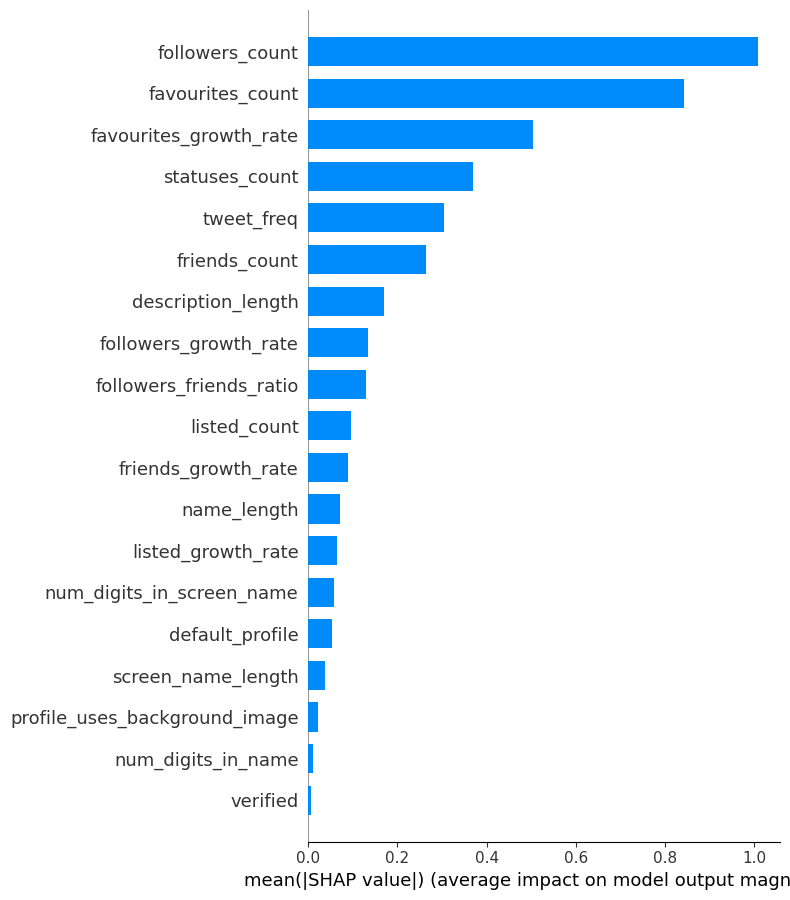

In [94]:
plot_bar_chart_of_mean_importance(xgb_model,df_X)

## D.2 SHAP summary plot

In [ ]:
def plot_shap_summary(xgb_model,df_X):
  '''
  Input
  =====
  xgb_model: The trained XGBoost classifier
  df_X: The input features dataframe we curated in section A.6

  Output
  ======
  Visualize the SHAP Summary plot.
  '''
  ## YOUR CODE HERE
  explainer = shap.TreeExplainer(xgb_model)
  shap_values = explainer.shap_values(df_X)
  shap.summary_plot(shap_values, df_X)
  ## END CODE

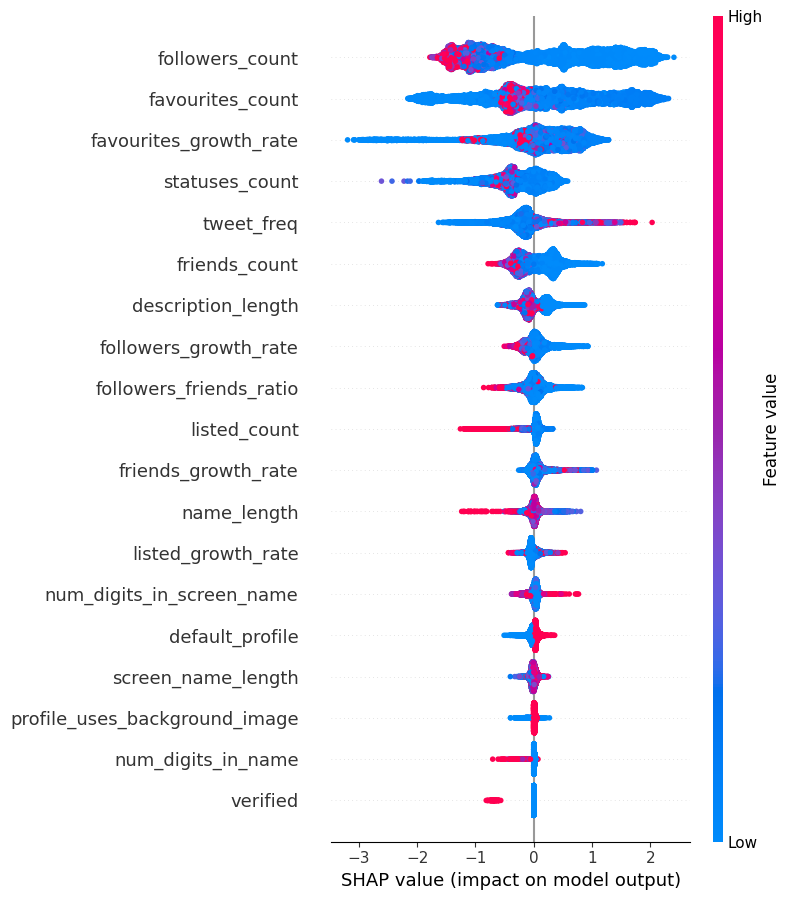

In [96]:
plot_shap_summary(xgb_model,df_X)

<b>Question 5: Which three features appear to be the most important in making the classification decisions?</b>

Your answer here: The top three features that are most important in making the classification decisions are followers count, favourites_count, and favourites growth rate as they are the on the top signifying higher importance in model prediction.